In [0]:
from google.colab import files
files.upload()

Saving logger.py to logger.py
Saving network.py to network.py
Saving room_simulation.py to room_simulation.py
Saving sine_dataset.py to sine_dataset.py


{'logger.py': b'# Code from https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/04-utils/tensorboard\r\nimport tensorflow as tf\r\nimport numpy as np\r\nimport scipy.misc \r\nfrom io import BytesIO\r\n\r\nclass Logger(object):\r\n    \r\n    def __init__(self, log_dir, suffix = ""):\r\n        """Create a summary writer logging to log_dir."""\r\n        self.writer = tf.summary.FileWriter(log_dir, filename_suffix=suffix)\r\n\r\n    def scalar_summary(self, tag, value, step):\r\n        """Log a scalar variable."""\r\n        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])\r\n        self.writer.add_summary(summary, step)\r\n\r\n    def histo_summary(self, tag, values, step, bins=1000):\r\n        """Log a histogram of the tensor of values."""\r\n\r\n        # Create a histogram using numpy\r\n        counts, bin_edges = np.histogram(values, bins=bins)\r\n\r\n        # Fill the fields of the histogram proto\r\n        hist = tf.HistogramProto()\r

In [0]:
!pip install pyroomacoustics
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from room_simulation import Simulation
from sine_dataset import SineData
from network import SSLConvNet as ConvNet
from network import SimpleNet
from logger import Logger
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Important paramters for training DNN
torch.cuda.empty_cache()
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
EPOCHS = 2000 * 4
BATCH_SIZE = int(64 / 2)
STEP_SIZE = 10

# Important simulation and data constants
NR_MICS = 2                                         # Number of mircophones in simulation
RAD = 50                                         # Radius of ellipse of microphone placements in cm
RADII = [50, 500, 5000]
ROOM_SIMS = []
DATASETS = []
MIC_L_DIST = (11, -10)                         # Distance between center and left microphone in cm on x-axis
MIC_R_DIST = (11, 10)                  # Distance between center and right microphone in cm on y-axis
# Absorption factor of the room in the simulation (1 = no reverb)
ABSORPTION = 0.0
# Minimal frequency of a sine wave according to Nyquist theorem
MAX_FREQ = 20000
SAMPLE_RATE = int(MAX_FREQ*2.2)                            # Sampling rate of signals in Hz
TIME = 1                                            # Time in seconds of sine wave
# MIN_LENGTH = SAMPLE_RATE*TIME + int(TIME*MAX_FREQ*0.2)                                  # Length a single sine signal should have
MIN_LENGTH = 65000 #[48000, 48000, 65000, 248000]
TO_RAD = np.pi/180                                  # Constant to convert degrees to radians
TO_DEG = 180/np.pi                                  # Constant to convert radians to degrees
print(MIN_LENGTH)

for rad in RADII:
  roomSim = Simulation(SAMPLE_RATE, rad, ABSORPTION, MIC_L_DIST, MIC_R_DIST, NR_MICS)
  ROOM_SIMS.append(roomSim)

  DATASETS.append(SineData(BATCH_SIZE, roomSim, TIME, MIN_LENGTH, MAX_FREQ))




cpu
65000


In [0]:
# # Plot room
# roomSim.plotRoom()

# Define custom loss function
class CosBorderLoss(torch.nn.Module):

    def __init__(self):
        super(CosBorderLoss, self).__init__()

    def forward(self, pred, target):
        radial = torch.abs(torch.cos(pred-target) - torch.cos(target-target))
        border = nn.functional.relu(pred-2*np.pi) + nn.functional.relu(-pred)
        return torch.sum(radial + border)

# Plot heatmap of custom loss function
# criterion = CosBorderLoss()
# cos_border_loss = np.zeros((360,360))
# i = 0
# j = 0
# for deg1 in np.arange(360):#(-360,720):
#     for deg2 in np.arange(360):  # (-360, 720):
#         rad1 = torch.as_tensor(deg1*TO_RAD)
#         rad2 = torch.as_tensor(deg2*TO_RAD)
#         cos_border_loss[i, j] = criterion(rad1, rad2)
#         j += 1
#     j = 0
#     i += 1
# ax = sns.heatmap(cos_border_loss)
# plt.title("Heatmap of loss function based on cos + border")
# plt.xlabel("Angles in degrees (should be range [-2pi,4pi])")
# plt.ylabel("Angles in degrees (should be range [-2pi,4pi])")
# plt.show()


----------- MODEL 0 -----------
Rad = 50


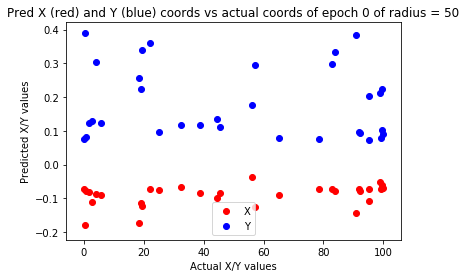

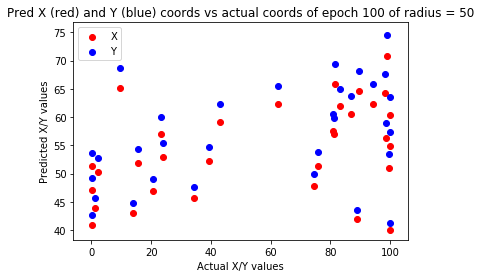

In [0]:
# Initialize network and train parameters
torch.cuda.empty_cache()
if EPOCHS > 0:
    for i in range(len(RADII)):
        print("----------- MODEL " + str(i) + " -----------")
        print("Rad = "+str(RADII[i]))
        net = ConvNet(DATASETS[i].MIN_LENGTH)
        net = net.double().to(device)
        criterion = nn.MSELoss()
        optimiser = torch.optim.Adam(net.parameters())
        logger = Logger("./logs", "RAD" + str(RADII[i]))
        dataLoader = DataLoader(DATASETS[i], batch_size=BATCH_SIZE)

        for curEpoch in range(EPOCHS):
            # Reset seed so random sine data is generated, otherwise RNG is repeated
            np.random.seed()

            # Gather input data & labels
            inL, inR, labelX, labelY = next(iter(dataLoader))
            inL = inL.double().to(device)
            inR = inR.double().to(device)
            labelX = labelX.double().to(device)
            labelY = labelX.double().to(device)

            # Training loop
            optimiser.zero_grad()
            outputX, outputY = net(inL, inR, debug = False)
            loss = criterion(torch.squeeze(outputX), labelX) + criterion(torch.squeeze(outputY), labelY)
            loss.backward()
            optimiser.step()

            if curEpoch % STEP_SIZE == 0: 
                # Log loss in tensorboard as scalars
                logger.scalar_summary("loss", loss.item(), curEpoch)

                outputXnp = outputX.detach().cpu().numpy()
                outputYnp = outputY.detach().cpu().numpy()
                labelXnp = labelX.detach().cpu().numpy()
                labelYnp = labelY.detach().cpu().numpy()

                # Plot the predicted vs actual angles
                if curEpoch % 100 == 0:
                    plt.scatter(labelXnp, outputXnp, c="red", label = "X")
                    plt.scatter(labelYnp, outputYnp, c="blue", label = "Y")
                    plt.title("Pred X (red) and Y (blue) coords vs actual coords of epoch " + str(curEpoch) + " of radius = " + str(RADII[i]))
                    plt.xlabel("Actual X/Y values")
                    plt.ylabel("Predicted X/Y values")
                    plt.legend()
                    plt.show()

                # Log gradients and weights in tensorboard as distributions and histograms
                for tag, value in net.named_parameters():
                    tag = tag.replace('.', '/')
                    logger.histo_summary(tag, value.data.cpu().numpy(), curEpoch)
                    logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), curEpoch)

                    # Log gradient of last layer as scalar
                    if "fc" in tag and "weight" in tag:
                        last_grad_norm = np.sqrt(np.mean(np.square(value.grad.data.cpu().numpy())))
                        logger.scalar_summary("last_grad_norm", last_grad_norm, curEpoch)

            curEpoch += 1

        del net, inL, inR, labelX, labelY    
        torch.cuda.empty_cache()

        torch.save(net.state_dict(), "ConvNet_Rad" + str(RADII[i]))



In [0]:
# Test set
net = net.to("cpu")     # To prevent GPU out of memory
inL, inR, labelX, labelY = next(iter(dataLoader))
outputX, outputY = net(inL, inR, False)#, debug = True)
print(np.std(np.abs(labelX.detach().numpy()-torch.squeeze(outputX.detach()).numpy())))
print(np.abs(labelX.detach().numpy()-torch.squeeze(outputX.detach()).numpy()))


NameError: ignored

0.9989065640725463 0.9620795099517729


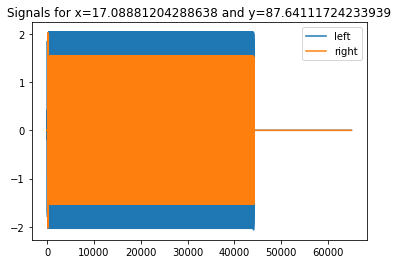

0.9989065640725463 0.9620795099517729


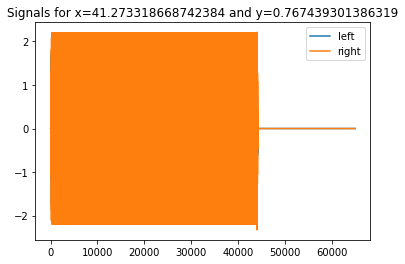

In [0]:
# Plot angles that look alike
# ind1 = 0
# ind2 = NR_ANGLES-1
# signalsL, signalsR = dataset.gatherSignals()
# plt.plot(signalsL[ind1], label="left")
# plt.plot(signalsR[ind1], label="right")
# plt.title("Signals for azi=" + str(azis[ind1]))
# plt.legend()
# plt.show()
# plt.plot(signalsL[ind2], label="left")
# plt.plot(signalsR[ind2], label="right")
# plt.title("Signals for azi=" + str(azis[ind2]))
# plt.legend()
# plt.show()

# Plot 2 signals to make sure data loads properly
inL, inR, labelX, labelY = next(iter(dataLoader))
plt.plot(inL.numpy()[0], label="left")
plt.plot(inR.numpy()[0], label="right")
print(np.std(inL.numpy()), np.std(inR.numpy()))
plt.title("Signals for x=" + str(labelX[0].item()) + " and y="+str(labelY[0].item()))
plt.legend()
plt.show()
plt.plot(inL.numpy()[1], label="left")
plt.plot(inR.numpy()[1], label="right")
print(np.std(inL.numpy()), np.std(inR.numpy()))
plt.title("Signals for x=" + str(labelX[1].item()) + " and y="+str(labelY[1].item()))
plt.legend()
plt.show()

